1. Introduction
2. load and check data
  
  - 2.1 load data
  - 2.2 outlier detection
  - 2.3 joining train and test set
  - 2.4 check for null and missing values

3. Feature analysis
  
  - 3.1 Numerical values
  - 3.2 Categorical values

4. Filling missing values

  - 4.1 Age

5. Feature Engineering

  - 5.1 Name/Title
  - 5.2 Family Size
  - 5.3 Cabin
  - 5.4 Ticket

6. Modeling
  
  - 6.1 Simple modeling

    - 6.1.1 Cross validate models

    - 6.1.2 Hyperparameter tuning for best models

    - 6.1.3 Plot learning curves

    - 6.1.4 Feature importances of tree based classifiers

  - 6.2 Ensembling modeling

    - 6.2.1 Combining models

  - 6.3 Prediction 

    - 6.3.1 Predict and Submit results   

# 1.Introduction

- 먼저 몇 가지 feature 분석을 표시한 다음 feature engineering에 집중할 것입니다. 

- 마지막 부분은 voting을 사용하여 타이타닉의 생존을 모델링하고 예측하는 것과 관련이 있습니다.

스크립트는 세 가지 주요 부분을 따릅니다:

- Feature 분석

- Feature engineering

- Modeling

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2.Load and check data

## 2.1 Load data

In [ ]:
#Load data
#### Load train and Test set

train = pd.read_csv('/content/drive/MyDrive/dietanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dietanic/test.csv')
IDtest = test['PassengerId']

## 2.2  Outlier Detection

In [ ]:
# 이상치 탐지

def detect_outliers(df, n, features):
  '''
  feature의 dataframe을 df로 가져오고 Tukey 검증에 따라 
  n개 이상의 이상값을 포함하는 관찰에 해당하는 인덱스 목록을 반환합니다.
  '''

  outlier_indices = []

  # feature(열)에 대한 반복
  for col in features:
    # 제 1 사분위수 (25%) : 데이터의 25%가 이 값보다 작거나 같음
    Q1 = np.percentile(df[col], 25)
    # 제 3 사분위수 (75%) : 데이터의 75%가 이 값보다 작거나 같음
    Q3 = np.percentile(df[col], 75)
    # 사분위간 범위 (IQR) : 제 1 사분위수와 제 3 사분위수 간의 거리, 데이터의 중간 50%에 대한 범위
    IQR = Q3 - Q1

    # 이상치 단계
    outlier_step = 1.5 * IQR

    # feature 열에 대한 이상치 인덱스 목록 결정
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # col에 대해 발견된 이사이를 이상치 지수 목록에 추가
    outlier_indices.extend(outlier_list_col)

  # 이상치를 2개 이상 포함하는 관측치 선택
  outlier_indices = Counter(outlier_indices) # Counter를 사용해서 이상치만 묶어서 딕셔너리로 만듦
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# Age, SibSp, Parch 및 Fare에서 이상치 감지
Outliers_to_drop = detect_outliers(train, 2, ['Age','SibSp', 'Parch', 'Fare'])

- 이상치는 예측(특히 회귀 문제의 경우)에 큰 영향을 미칠 수 있으므로 특이치를 관리하기로 했습니다.

- Tukey 방법을 사용하여 분포값(IQR)의 1분위와 3분위 사이에 구성된 사분위간 범위를 정의하는 계수를 검출했습니다. 이상값은 (IQR +- 이상치 단계) 외부의 feature 값이 있는 행입니다.

- Numerical feature 값(Age, SibSp, Parch 와 Fare)에서 이상값을 감지하기로 했습니다. 그런 다음 이상치를 최소 두 개 이상 나온 숫자 값을 가진 행으로 간주했습니다.

In [ ]:
train.loc[Outliers_to_drop] # 이상치 행을 보여줌

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 이상치를 탐지합니다.  28, 89, 342번 승객은 티켓 요금이 높다는 것을 확인했습니다.

- 나머지 7개는 SibSp값이 매우 높습니다.

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True) # 행기준으로 버리고 인덱스 초기화함

## 2.3 train test set 합치기

In [ ]:
# 범주형 변환 중에 동일한 수의 형상을 얻기 위해 train과 test 데이터셋 결합
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

- 범주 변환 중에 동일한 수의 feature를 얻기 위해 훈련 및 테스트 데이터셋에 합친다(feature engineering 참조).

## 2.4 null값과 misssing값 확인

In [ ]:
# 빈값이나 NaN 값을 NaN으로 채우기
dataset = dataset.fillna(np.nan)

# null값 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age와 Cabin feature는 결측값의 중요한 부분을 차지합니다.

- Survived 누락 값은 결합 테스트 데이터셋에 해당합니다(Survived 열은 테스트셋에 존재하지 않으며 train과 test set을 연결할 때 NaN값으로 대체됨).

In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
### 데이터 요약
# 요약 및 통계
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3.Feature analysis

## 3.1 Numerical values

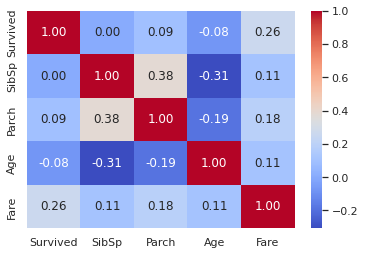

In [ ]:
# Numerical values(SibSp Parch Age and Fare 값)와 Numerical 값 간의 상관 행렬
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), 
                annot=True,  # 값 표시 유무
                fmt = '.2f', # 값의 데이터 타입(현재 데이터 타입은 float이고, 소수점 둘째 자릿수까지 표시)
                cmap='coolwarm') # 히트맵의 색깔 결정

- 오직 Fare feature만 Survived와 뜻 깊은 상관이 있는 것 같습니다.

- 다른 feature가 유용하지 않다는 것은 아닙니다. 이러한 feature의 하위 집단은 생존과 상관관계가 있을 수 있습니다. 이를 확인하려면 이러한 기능을 자세히 살펴봐야 합니다.

### SibSp

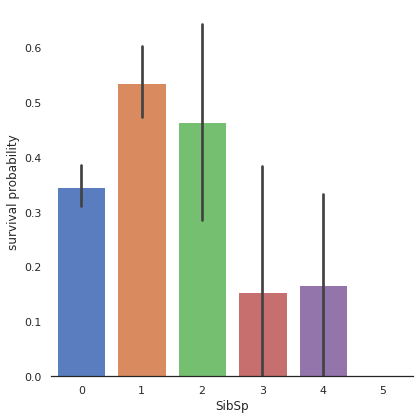

In [ ]:
# SibSp feature와 Survived 비교
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 형제자매/배우자가 많은 승객들은 살아남을 기회가 적은 것 같습니다.

- 싱글 승객(0 SibSp) 또는 다른 2명(SibSp 1 또는 2)이 생존할 가능성이 더 높습니다.

- 이러한 관찰은 매우 흥미롭습니다. 이러한 범주를 설명하는 새로운 기능을 고려할 수 있습니다(Feature Engineering 참조).

### Parch

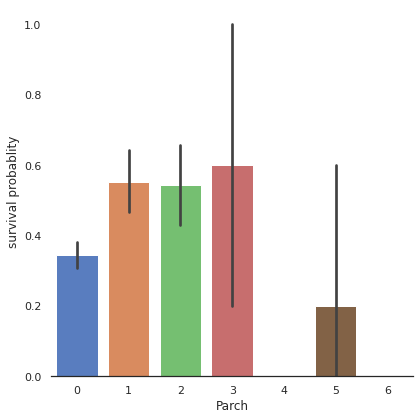

In [ ]:
# Parch feature와 Survived 비교
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True) # 왼쪽 테두리 제거
g = g.set_ylabels('survival probablity')

- 소가족은 단일가족(Parch 0), 중간가족(Parch 3,4), 대가족(Parch 5,6)보다 생존 기회가 더 많습니다.

- 부모/자녀가 3명인 승객의 생존에 중요한 표준 편차가 있으므로 주의하십시오.

### Age

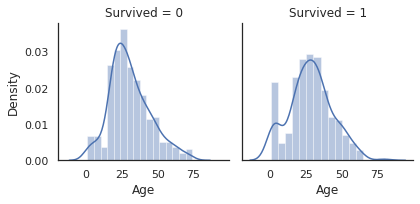

In [ ]:
# Age와 Survived 비교
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

- `FacetGrid`클래스는 여러 플롯에 대한 그리드를 생성하여 데이터의 다른 하위 집합과 데이터 분포 간의 관계를 시각화하는데 사용됩니다. 행및 열 축을 지정하여 그리드에 데이터셋을 그립니다. 복잡한 데이터셋로 작업할 때 편리합니다.

- `sns.FacetGrid()`생성자를 사용하여 그리드를 생성하고 행과 열값으로 초기화합니다. 그리고 `map()`함수를 사용하여 그리기 원하는 플롯과 변수를 지정합니다. 

- Age 분포는 정규 분포일 수도 있는 꼬리 분포인 것 같습니다.

- 우리는 생존한 하위 집단과 생존하지 않은 하위 집단에서 Age 분포가 같지 않다는 것을 알아차린다. 실제로 살아남은 젊은 승객에 해당하는 봉우리가 있다. 우리는 또한 60-80세 사이의 승객들이 덜 살아남았다는 것을 볼 수 있다.

- 따라서, 'Age'가 Survived'과 상관관계가 없다고 하더라도, 우리는 생존 가능성이 다소 높은 승객들의 Age 범주가 있다는 것을 알 수 있다.

- 아주 어린 승객들이 생존할 기회가 더 많은 것 같다.

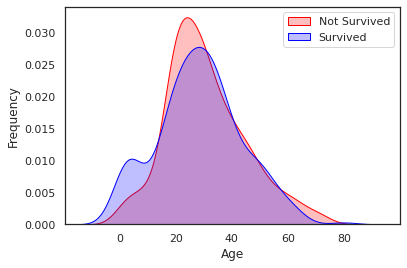

In [ ]:
# Age 분포 파악

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],color='Red', shade=True) # data에 pandas의 dataframe, 파이썬의 list형태, numpy의 배열이 들어갈 수 있음
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax = g, color='Blue', shade=True) # shade는 곡선 아래의 공각을 음영 처리할지 결정
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

- 우리가 두 밀도를 중첩할 때, 우리는 아기들과 매우 어린 아이들에게 대응하는 피크(0-5사이)를 분명히 볼 수 있습니다.

### Fare

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
# Fare값 중 누락된 것을 중위수 값으로 채움
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

- 결측값이 하나 있기 때문에 예측에 중요한 영향을 미치지 않은 중위수 값을 채우기로 결정했습니다.

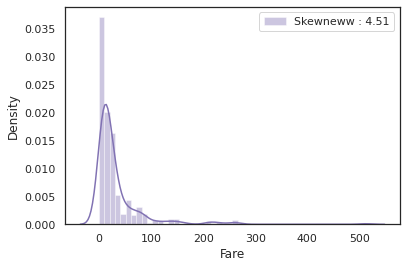

In [ ]:
# Fare 분포 보기

g = sns.distplot(dataset['Fare'], color='m', label='Skewneww : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

- 우리가 볼 수 있듯이, Fare 분포는 매우 치우쳐져있다. 이로 인해 모형의 가중치가 매우 높을 수 있습니다(크기 조정되더라도).

- 이 경우 로그 함수로 변환하여 이러한 왜도를 줄이는 것이 좋습니다.

In [ ]:
# Fare에 왜도를 줄이기 위해 log함수로 변환
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

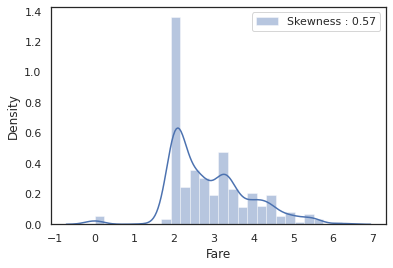

In [ ]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

- 로그 변환 후 왜도가 명확하게 감소됨

## 3.2 Categorical values

### Sex

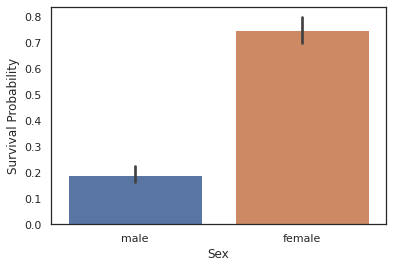

In [ ]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [ ]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 생존 가능성이 적다는 것은 분명하다.

- 그래서 성별은 생존을 예측하는데 중요한 역할을 할 수도 있습니다.

- 타이타닉 영화(1997)를 본 사람들에게, 나는 우리 모두가 피난 중에 이 문장을 기억한다고 확신한다: '여자와 아이들이 먼저'.

### Pclass

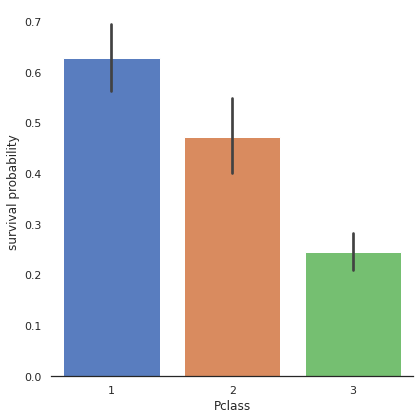

In [ ]:
# Pclass와 Survived 비교
g = sns.factorplot(x='Pclass', y='Survived',data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

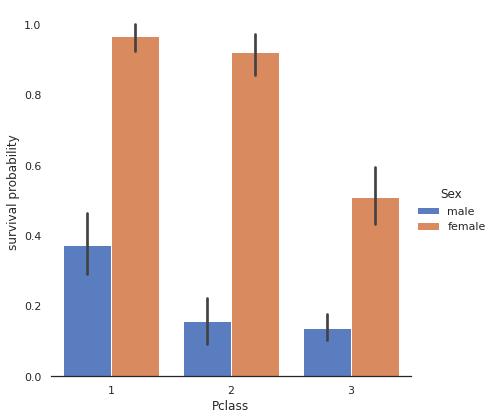

In [ ]:
# Pcalss와 Survived를 Sex를 기준으로 비교

g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 승객 생존율은 3개 클래스에서 동일하지 않습니다. 일등성 승객들은 이등석과 삼등석 승객들보다 생존할 기회가 더 많았습니다.

- 이러한 경향은 남성 승객과 여성 승객 모두를 볼 때 보존됩니다.

### Embarked

In [ ]:
dataset['Embarked'].isnull().sum()

2

In [ ]:
# dataset의 Embarked NaN값을 가장 빈도가 높은 값인 'S'로 채움
dataset['Embarked']= dataset['Embarked'].fillna('S')

- 결측값이 두 개이므로 'Embarked'(S)의 가장 빈도가 높은 값으로 채우기로 결정했습니다.

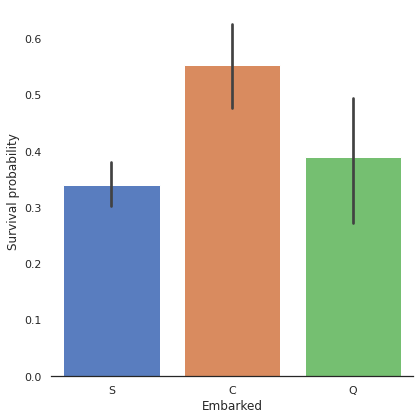

In [ ]:
# Embarked와 Survived 비교
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

- C에서 오는 승객들이 생존할 기회가 더 많아 보인다.

- 일등석의 비율이 Q, S보다 C에서 온 사람들이 더 높다는 것이다.

- Pclass 분포와 Boated 분포를 살펴보겠습니다.

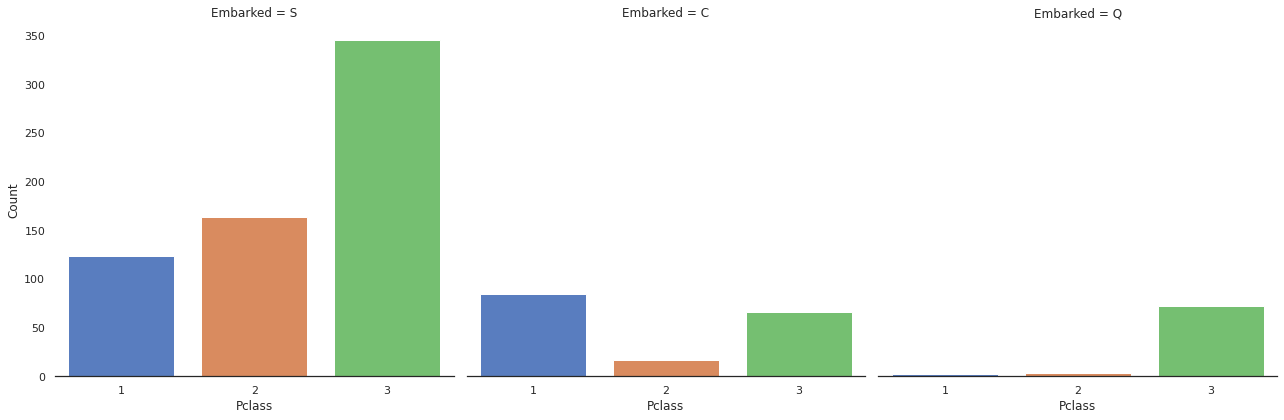

In [ ]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- 실제로 3등석은 S와 Q에서 오는 승객들에서 가장 빈번한 반면, C의 승객들은 대부분 생존율이 가장 높은 1등석이다.

- 왜 1등석이 생존율이 더 높은지 설명할 수 없다. 일등석 승객들이 그들의 영향 때문에 대피하는 동안 우선순위가 매겨졌다는 것이다.

# 4. missing값 채우기

## 4.1 Age

- 보시다시피, 연령 열에는 전체 데이터 세트에 256개의 결측값이 포함되어 있습니다.

- 생존 기회가 더 많은 하위 모집단(예: 어린이)이 있으므로 연령 특징을 유지하고 누락된 값을 귀속시키는 것이 바람직하다.

- 이 문제를 해결하기 위해, 나는 Age(Sex, Parch, Pclass 및 SibSp)와 가장 상관관계가 있는 특징들을 살펴보았다.

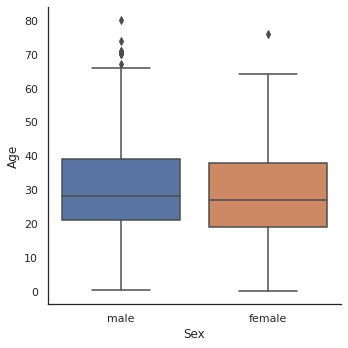

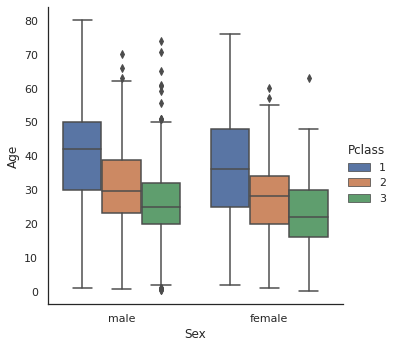

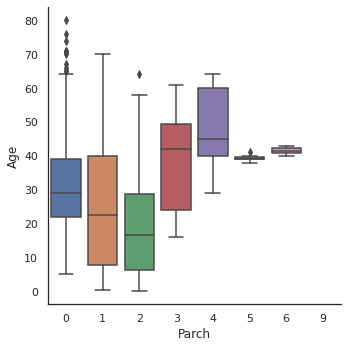

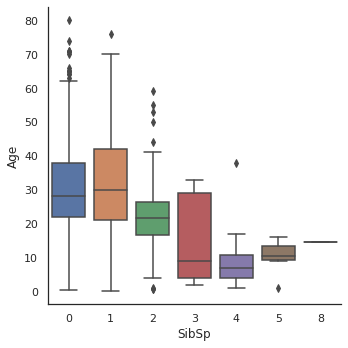

In [ ]:
# Age vs Sex, Parch, Pclass와 SibSp 비교
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

- 연령 분포는 남성과 여성 하위 모집단에서 동일한 것으로 보이며, 따라서 성별은 연령을 예측하는데 유용하지 않습니다.

- 그러나 1등석 승객은 3등석 승객보다 나이가 많은 2등석 승객보다 나이가 많다.

- 더욱이 승객이 부모/자녀를 많이 가질수록 그는 나이가 많고 형제/배우자를 많이 가질수록 그는 젊어진다.

In [ ]:
# 성별을 남성의 경우 0으로, 여성의 경우 1로 범주형 값으로 변환함
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

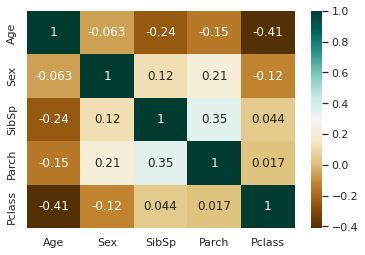

In [ ]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp','Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

- 상관관계 히트맵은 Parch를 제외한 factorplot 관측치를 확인합니다. 나이는 성별과는 상관관계가 없지만, Pclass, Parch, SibSp와는 부정적인 상관관계가 있다.

- Parch와 성별 plot에서 성별은 부모/자녀 수에 따라 증가하고 있습니다. 하지만 일반적인 상관관계는 부정적이다.

- 그래서 나는 실종된 나이를 귀속시키기 위해 SibSp, Parch, Pclass를 사용하기로 결정했습니다.

- 전략은 Pclass, Parch 및 SibSp에 따라 유사한 행의 중위수 연령으로 Age를 채우는 것입니다.

In [ ]:
# missing value of Age 채우기
## Pclass, Parch 및 SibSp에 따라 유사한 행의 중위수 연령으로 채우기
# age 행 NaN 인덱스
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

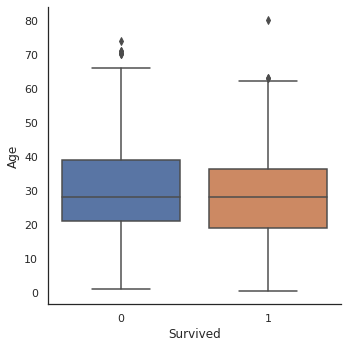

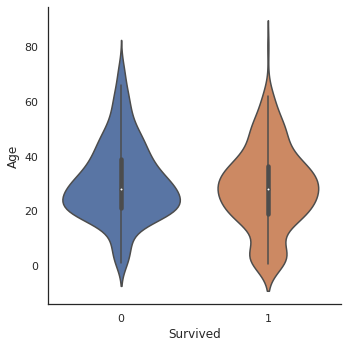

In [ ]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y= 'Age', data=train, kind='violin')

- 생존군과 비생존군의 연령 중위수 값 사이에는 차이가 없습니다.

- 그러나 생존한 승객들의 바이올린 플롯에서 우리는 여전히 매우 어린 승객들이 더 높은 생존율을 가지고 있다는 것을 알아차릴 수 있습니다.

# 5. Feature Engineering

## 5.1 Name/Title

In [ ]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
# Name에서 title 뽑기
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

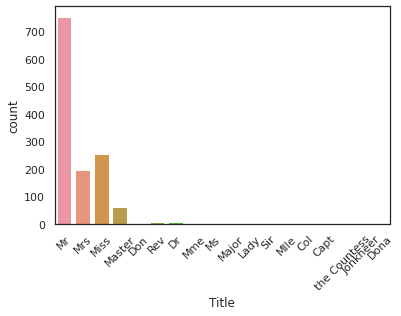

In [ ]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) # xticks생성 하고 45도 각도로 돌리기

- 데이터셋에는 17개의 title이 있으며, 대부분 매우 희귀하며 4개의 범주로 그룹화할 수 있습니다.

In [ ]:
# title을 범주형 값으로 변환
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',\
                                             'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

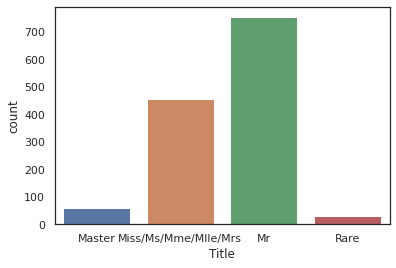

In [ ]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

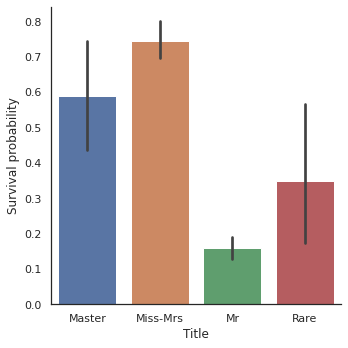

In [ ]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival probability')

- '여자와 아이가 먼저'

- 희귀한 타이틀을 가진 승객들이 생존할 기회가 더 많다는 것은 흥미로운 사실이다.

In [ ]:
# Drop Name variable
dataset.drop(labels=['Name'], axis=1, inplace=True)

## 5.2 Family Size

- 대가족들이 대피하는 동안 누나/동생/부모님을 찾아 대피하는데 더 어려움을 겪을 것이라는 것을 우리는 상상할 수 있다.

- 그래서 저는 SibSp, Parch와 1(승객 포함)의 합인 'Fize'(Family_Size) feature를 만들기로 했습니다.

In [ ]:
# SibSp 및 Parch에서 Family_Size 열 만들기
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

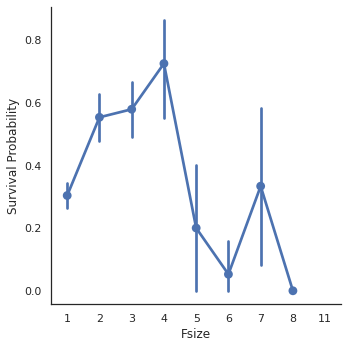

In [ ]:
g = sns.factorplot(x='Fsize', y='Survived', data = dataset)
g = g.set_ylabels('Survival Probability')

- 가족 규모가 중요한 역할을 하는 것처럼 보인느데, 대가족의 생존 확률은 최악이다.

- 추가적으로, 나는 4개의 가족 크기 카테고리를 만들기로 결정했다.

In [ ]:
# Family Size 새로운 feature 만들기
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

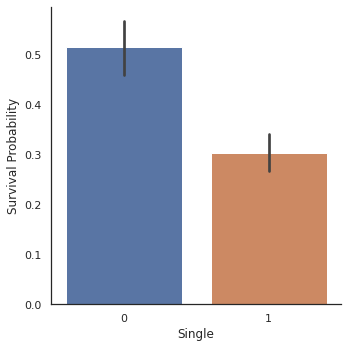

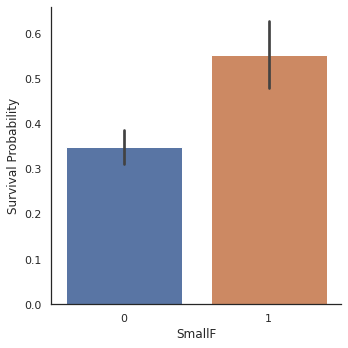

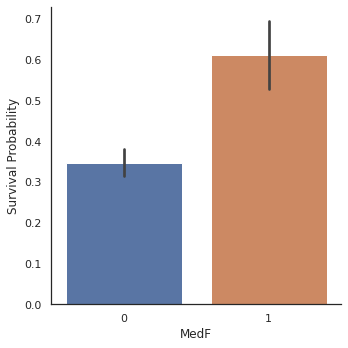

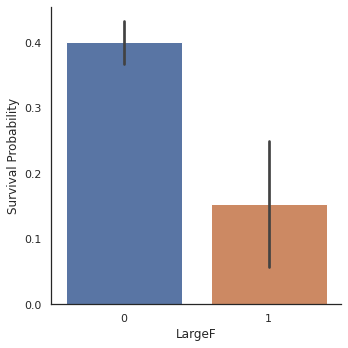

In [ ]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='LargeF', y='Survived',data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

- 가족 크기 범주 factorplot은 혼자 및 대가족보다 중소가족이 생존할 기회가 더 많다는 것을 보여준다.

In [ ]:
# title과 Embarked 지시자값으로 변환
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

- 지금 이 단계에서 우리는 22개의 feature를 가지고 있다.

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [ ]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].isnull().sum()

1007

- Cabin feature열에는 292개의 값과 1007개의 결측값이 있습니다.

- 객실이 없는 승객은 객실번호 대신 누락된 값이 표시되는 것으로 생각했습니다.

In [ ]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Cabin 번호를 'X'유형으로 교체함
dataset['Cabin']=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

- Cabin 첫 글자는 데스크를 가리키며, 이 정보는 타이타닉호에 탑승한 승객의 가능한 위치를 나타내기 때문에 이 정보만을 유지하기로 했다.

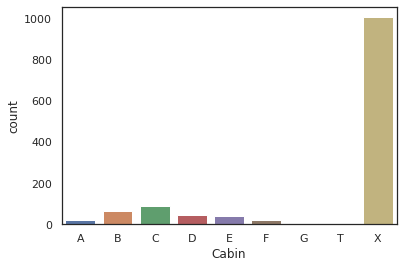

In [ ]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

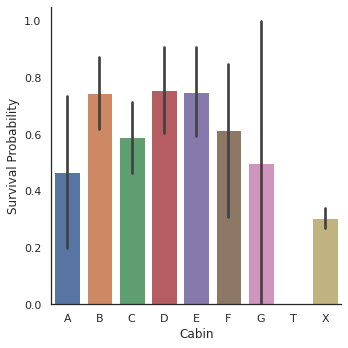

In [ ]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

- 객실이 있는 승객의 수가 적기 때문에 생존 확률을 중요한 표준 편차를 가지며 다른 책상에 있는 승객의 생존 확률을 구별할 수 없습니다.

- 그러나 우리는 일반적으로 객실을 가진 승객이 (X)가 없는 승객보다 생존할 수 있는 기회가 더 많다는 것을 알 수 있다.

- 이는 특히 객실 B,C,D,E 및 F에 해당됩니다.

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')  
# prefix는 생성할 dummy variable의 column 이름 앞에 붙을 prefix를 지정

## 5.4 Ticket

In [ ]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 같은 접두사를 공유하는 티켓이 함께 배치된 Cabin에 예약될 수 있다는 것을 의미할 수 있다. 그러므로 그것은 배 안에 실제로 Cabin을 배치하는 것으로 이어질 수 있다.

- 동일한 접두사를 가진 티켓은 클래스와 생존이 유사할 수 있습니다.

- 그래서 나는 티켓 feature 열을 티켓 접두어로 바꾸기로 했다. 그게 더 유익할 수도 있다

In [ ]:
# 티켓 접두사를 추출하여 티켓을 다룸 접두사가 없으면 X를 반환
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0]) # Take prefix
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Ticket'],prefix='T')

In [ ]:
# Pclass를 범주형 변수를 바꾸기
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [ ]:
# 불필요한 변수 버리기
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. MODELING

In [ ]:
## train dataset과 test dataset 분리하기
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1, inplace=True)

In [ ]:
# train feature와 라벨 분리하기

train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'],axis=1)

## 6.1 Simple modeling

### 6.1.1 Cross validate models

10개의 유명한 분류기를 비교하고 계층화된 Kfold 교차 검증 절차를 통해 각 분류기의 평균 정확도를 평가했다.

- SVC

- Decision Tree

- AdaBoost

- Random Forest

- Extra Trees

- Gradient Boosting

- Multiple layer perceptron (neural network)

- KNN

- Logistic regression

- linear Discriminant Ananlysis

In [ ]:
# Kfold 계층화 교차 검증 모델
kfold = StratifiedKFold(n_splits=10)

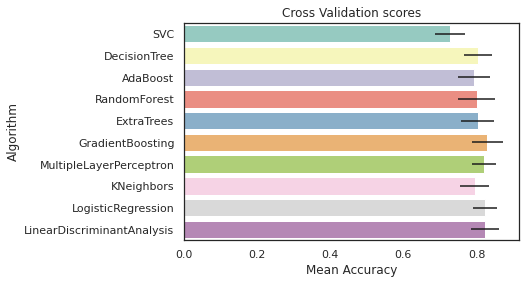

In [ ]:
# 모델링 다른 알고리즘 검정 단계 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 'Algorithm':['SVC', 'DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','MultipleLayerPerceptron', 'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data= cv_res, palette='Set3', orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation scores')

GradientBoosting, MLP perceptron, logisticRegression과 LinearDisciminantAnalysis를 앙상블해보겠다.

In [ ]:
# Gradient Boosting tuning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'], # 최적화할 loss 함수
                'n_estimators' : [100,200,300], # 수행할 부스팅 단계 수 / Gradient Boosting은 과적합에 강하므로 숫자가 많으면 일반적으로 성능이 향상됨 
                'learning_rate': [0.1, 0.05, 0.01], 
                'max_depth': [4,8], # 최대 트리의 노드 수
                'min_samples_leaf':[100,150], # 리프 노드에 있어야할 최소 샘플 수
                'max_features':[0.3, 0.1]} # 최적의 분할 을 찾을 때 고려해야할 feature 수
gsGBC = GridSearchCV(GBC,param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best Score
print(gsGBC.best_score_)

# Best parameters
print(gsGBC.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0.8286006128702759
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}


In [ ]:
# MLP perceptron
mlp = MLPClassifier()
mlp_param_grid = {
    'hidden_layer_sizes': [(50,),], # 은닉층의 뉴런의 수
    'max_iter' : [50], # 최대 반복
    'solver' : ['sgd','adam'], # 가중치 최적화
    'activation' : ['identity', 'logistic', 'tanh', 'relu'], # 활성화 함수
    'alpha': [0.0001,0.001, 0.01], # L2 규제값
    'learning_rate': ['constant','adaptive', 'invscaling']} #learning rate schedule
gsMLP = GridSearchCV(mlp, param_grid = mlp_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsMLP.fit(X_train, Y_train)

MLP_best = gsMLP.best_estimator_

# Best Score
print(gsMLP.best_score_)

# Best parameters
print(gsMLP.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0.8354187946884576
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 50, 'solver': 'adam'}


In [ ]:
# logistic Regression
lg = LogisticRegression()
lg_param_grid = {'penalty':['l1','l2','elasticnet'], # 노드에 가할 페널티
                 'C':[0.001, 0.01,0.1, 1, 10, 100] } # 정규화 강도를 의미하며, 양의 부동 소수여야 함
gsLG = GridSearchCV(lg, param_grid=lg_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsLG.fit(X_train, Y_train)

LG_best = gsLG.best_estimator_

# best score
print(gsLG.best_score_)

# best parameter
print(gsLG.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
0.8240296220633301
{'C': 0.1, 'penalty': 'l2'}


In [ ]:
# lineardiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_param_grid = {'solver':['svd', 'lsqr', 'eigen']} # solver

gsLDA = GridSearchCV(lda, param_grid=lda_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsLDA.fit(X_train, Y_train)

LDA_best = gsLDA.best_estimator_

# best score
print(gsLDA.best_score_)

# best parameter
print(gsLDA.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
0.8229315628192033
{'solver': 'svd'}


### 6.1.3 learning curve 그래프

- Learning Curve는 train set에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인하는 좋은 방법이다.

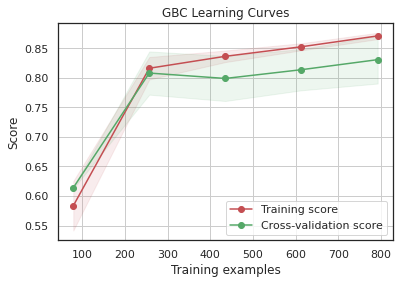

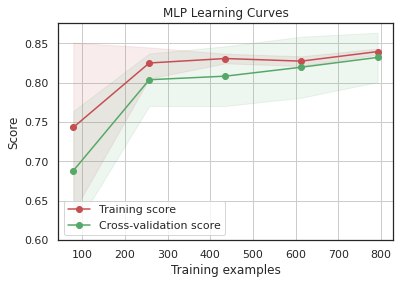

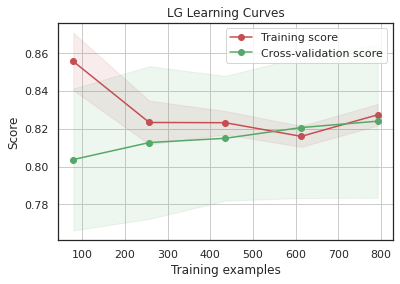

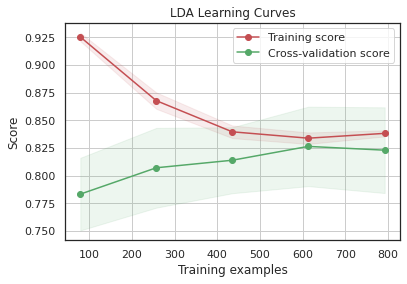

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  ''' 테스트 및 훈련 학습 곡선의 간단한 그림 생성'''
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label = 'Cross-validation score')

  plt.legend(loc='best')
  
  return plt

g = plot_learning_curve(GBC_best, 'GBC Learning Curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(MLP_best, 'MLP Learning Curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(LG_best, 'LG Learning Curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(LDA_best, 'LDA Learning Curves', X_train, Y_train, cv=kfold)

### 6.1.4 트리 기반 분류기의 Feature Importance

- 승객 생존 예측을 위한 가장 유용한 특징을 보기 위해, 나는 4개의 트기 기반 분류기에 대한 feature importance를 표시했다.

In [ ]:
# Adaboost /base_estimator로 시작하던 것이  estimator 으로 변경 
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"estimator__criterion" : ["gini", "entropy"],
              "estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

# best score
print(gsadaDTC.best_score_)

# best params
print(gsadaDTC.best_params_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
0.8275536261491316
{'algorithm': 'SAMME.R', 'estimator__criterion': 'entropy', 'estimator__splitter': 'best', 'learning_rate': 0.3, 'n_estimators': 2}


In [ ]:
Extc = ExtraTreesClassifier()

ex_param_grid = {"max_depth":[None],
                 'max_features':[1,3,10],
                 'min_samples_split':[2,3,10],
                 'bootstrap':[False],
                 'min_samples_leaf':[1,3,10],
                 'n_estimators':[100,300],
                 'criterion':['gini']}

gsExtc = GridSearchCV(Extc, param_grid= ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtc.fit(X_train,Y_train)

Extc_best = gsExtc.best_estimator_

# best score
print(gsExtc.best_score_)

# best params
print(gsExtc.best_params_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
0.8286133810010214
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Random Forest
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth': [None],
                 'max_features':[1,3,10],
                 'min_samples_leaf':[1,3,10],
                 'min_samples_split':[2,3,10],
                 'bootstrap':[False],
                 'n_estimators':[100,300],
                 'criterion':['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best Score
print(gsRFC.best_score_)

# Best params
print(gsRFC.best_params_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
0.8308605720122575
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}


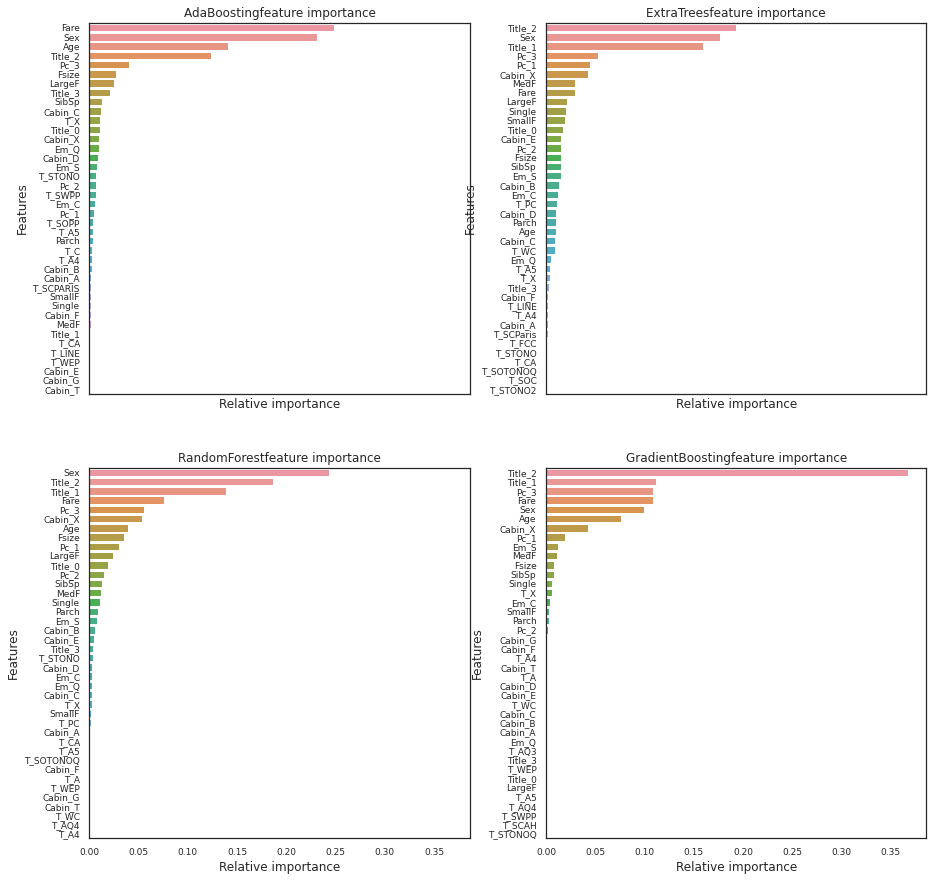

In [ ]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows= nrows, ncols=ncols, sharex = 'all', figsize = (15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees',Extc_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
    g.set_xlabel('Relative importance', fontsize=12)
    g.set_ylabel('Features', fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + 'feature importance')
    nclassifier +=1

4개의 트리 기반 분류기(Adaboost, ExtraTree, RandomForest 및 GradientBoost)에 대한 Feature importance를 표시한다.

우리는 네 개의 분류기가 상대적인 중요성에 따라 다른 최상위 특징을 가지고 있다는 것에 주목한다. 그것은 그들의 예측이 같은 특징에 근거하지 않는다는 것을 의미한다.

그럼에도 불구하고, 그들은 'Fare', 'Title_2', 'Age', 'Sex'와 같은 분류를 위한 몇 가지 공통적인 중요한 feature들을 공유한다.

- Title2는 Mrs/Mlle/Mme/Miss/Ms 범주가 Sex와 높은 상관관계가 있음을 나타냅니다.

- Pc_1, Pc_2, Pc_3 및 요금은 승객의 일반적인 사회적 지위를 나타냅니다.

- Sex와 Title_2(Mrs/Mlle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 의미합니다.

- Age와 Title_1(Master)은 승객의 연령을 말합니다.

- Fsize, LargeF, MedF, Single은 승객 패밀리의 크기를 의미한다.

이 4가지 분류기의 feature importance에 따르면, 생존 예측은 보트 안의 위치보다는 승객의 나이, 성별, 가족 규모, 사회적 지위와 더 관련이 있는 것으로 보인다.

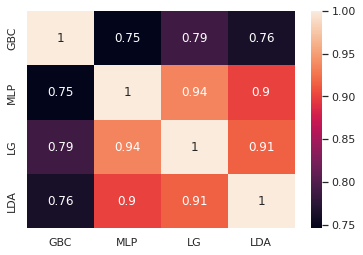

In [ ]:
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')
test_Survived_MLP = pd.Series(MLP_best.predict(test), name='MLP')
test_Survived_LG = pd.Series(LG_best.predict(test), name='LG')
test_Survived_LDA = pd.Series(LDA_best.predict(test), name='LDA')

ensemble_results = pd.concat([test_Survived_GBC, test_Survived_MLP, test_Survived_LG, test_Survived_LDA], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

## 6.2 Ensemble Modeling

### 6.2.1 Combining models

In [ ]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best), ('extc', Extc_best), ('adac',ada_best), ('gbc', GBC_best)],
                           voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

Voting과 Bagging은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식이라는 점에서 유사하다.

- 차이점은 Voting은 서로 **다른 알고리즘**을 가진 분류기가 **같은 데이터셋**을 기반으로 학습되고 결합하는 것다.

- Bagging은 **같은 알고리즘** 유형의 모델들이지만 데이터 샘플링을 다르게 하여 **학습 데이터셋이 각각 다르다**(단 교차 검증과 다르게 데이터셋간 중첩을 허용).

voting은 Hard voting과 Soft voting이 있다.

- Hard voting은 다수의 classifier의 예측 결괏값을 **다수결**로 최종 class를 결정한다.

- Soft voting은 다수의 classifier의 예측 결괏값간 확률을 **평균**하여 최종 class를 결정한다. 

- 일반적으로 Soft voting이 성능이 우수하여 주로 사용한다.

주요 파라미터

- estimator = 리스트 형식으로 튜플 형식의 앙상블할 classifier를 넣어준다.

- voting = voting 방식을 말하고 default는 Hard이다.


## 6.3 Prediction

### 6.3.1 Predict and Submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('/content/drive/MyDrive/dietanic/ensemble_python_voting.csv', index=False)

# 참고

https://dsbook.tistory.com/51

https://www.delftstack.com/ko/howto/seaborn/seaborn-facetgrid-python/

https://hleecaster.com/python-seaborn-kdeplot/

https://libertegrace.tistory.com/entry/Classification-2-%EC%95%99%EC%83%81%EB%B8%94-%ED%95%99%EC%8A%B5Ensemble-Learning-Voting%EA%B3%BC-Bagging


# 필사후 느낀점

같은 데이터셋으로 다른 Feature Engineering 기법을 사용하는 것이 신기했다. 앞서서 했던 필사에서는 Cabin feature를 사용하지 않았지만 이번 필사에서는 Cabin을 살리면서 진행한 점이 인상적이다.

그리고 voting classifier를 확실히 공부한 것 같다. 그리고 다양한 분류기를 사용해본 좋은 경험이 됐고 learning_curve를 사용해서 어디서 과적합된 것인지 확인한 부분도 배울 점이라고 생각했다.

